# Classifying CIFAR100 images using ResNets, Regularization and Data Augmentation in PyTorch

In this notebook, we'll use the following techniques to train a state-of-the-art model in classifying images from the CIFAR100 dataset:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

### Using a GPU for faster training

You can use a [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU) to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:

* _Google Colab_: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
* _Kaggle_: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
* _Binder_: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
* _Linux_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html).
* _Windows_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html).
* _macOS_: macOS is not compatible with NVIDIA GPUs


If you do not have access to a GPU or aren't sure what it is, don't worry, you can execute all the code in this tutorial just fine without a GPU.

Let's begin by importing the required libraries.

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder, CIFAR100
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
project_name='cifar100-resnet18'

## Preparing the CIFAR100 Dataset

This notebook is an extension to the notebook [Image Classification using Resnet8 in PyTorch](https://jovian.ai/kumar-shailesh1597/05b-cifar10-resnet), where we trained a deep convolutional neural network to classify images from the CIFAR10 dataset with around 75% accuracy. 

Here are some images from the CIFAR100 dataset:

![cifar100](https://web.stanford.edu/~hastie/CASI_files/DATA/cifar100.jpg)


Let's begin by downloading the dataset and creating PyTorch datasets to load the data.

In [5]:
!pip install opendatasets

In [7]:
import opendatasets as od

od.download('https://www.kaggle.com/minbavel/cifar-100-images')

  4%|▎         | 5.00M/140M [00:00<00:03, 42.5MB/s]

100%|██████████| 140M/140M [00:00<00:00, 249MB/s]


In [9]:
data_dir = './cifar-100-images/CIFAR100'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/TRAIN")
print(classes)
print(len(classes))

['TRAIN', 'TEST']
['skunk', 'caterpillar', 'aquarium_fish', 'house', 'porcupine', 'castle', 'bear', 'cloud', 'snake', 'rabbit', 'fox', 'maple_tree', 'hamster', 'bed', 'cattle', 'chair', 'seal', 'squirrel', 'couch', 'bottle', 'pine_tree', 'tank', 'keyboard', 'raccoon', 'cockroach', 'pickup_truck', 'orange', 'spider', 'beetle', 'streetcar', 'dinosaur', 'tulip', 'wardrobe', 'lion', 'train', 'clock', 'crab', 'palm_tree', 'rocket', 'forest', 'mouse', 'shrew', 'chimpanzee', 'sweet_pepper', 'tiger', 'telephone', 'road', 'bicycle', 'woman', 'butterfly', 'wolf', 'lizard', 'bus', 'mountain', 'poppy', 'beaver', 'trout', 'man', 'bridge', 'pear', 'plain', 'table', 'ray', 'whale', 'motorcycle', 'crocodile', 'dolphin', 'snail', 'plate', 'cup', 'oak_tree', 'girl', 'apple', 'baby', 'television', 'skyscraper', 'flatfish', 'kangaroo', 'turtle', 'worm', 'elephant', 'lobster', 'tractor', 'bee', 'willow_tree', 'rose', 'can', 'sunflower', 'possum', 'sea', 'bowl', 'otter', 'shark', 'camel', 'lamp', 'lawn_mowe

We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [10]:
# Data transforms (normalization & data augmentation)
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [11]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/TRAIN', train_tfms)
valid_ds = ImageFolder(data_dir+'/TEST', valid_tfms)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

In [12]:
batch_size = 500

In [13]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [14]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

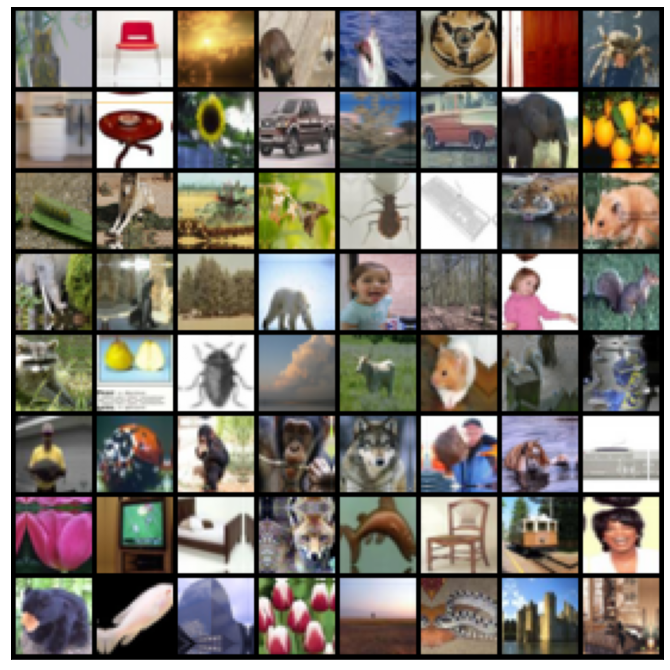

In [15]:
show_batch(train_dl)


## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let's check our default device it could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [17]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

Here we are using resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

We will use the ResNet18 architecture in this project:

![resnet-18](https://296830-909578-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2019/06/Artboard-1-5.svg)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [47]:
def bn_re(out_channels, pool=False):
    layers = [nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

def conv_block(in_channels, out_channels, conv2=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if conv2: layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
    return nn.Sequential(*layers)

class ResNet18(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.bn_re1 = bn_re(64)
        self.res1 = conv_block(64, 64, conv2=True)
        self.bn_re2 = bn_re(64)
        self.res2 = conv_block(64, 64, conv2=True)
        self.bn_re3 = bn_re(64)
        self.res3 = conv_block(64, 128, conv2=True)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn_re4 = bn_re(128, pool=True)
        self.res4 = conv_block(128, 128, conv2=True)
        self.bn_re5 = bn_re(128)
        self.res5 = conv_block(128, 256, conv2=True)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn_re6 = bn_re(256, pool=True)
        self.res6 = conv_block(256, 256, conv2=True)        
        self.bn_re7 = bn_re(256)
        self.res7 = conv_block(256, 512, conv2=True)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn_re8 = bn_re(512, pool=True)
        self.res8 = conv_block(512, 512, conv2=True)
                
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.bn_re1(out)
        out = self.res1(out) + out
        out = self.bn_re2(out)
        out = self.res2(out) + out
        out = self.bn_re3(out)
        out = self.res3(out) + self.conv3(out)
        out = self.bn_re4(out)
        out = self.res4(out) + out
        out = self.bn_re5(out)
        out = self.res5(out) + self.conv5(out)
        out = self.bn_re6(out)
        out = self.res6(out) + out
        out = self.bn_re7(out)
        out = self.res7(out) + self.conv7(out)
        out = self.bn_re8(out)
        out = self.res8(out) + out
        out = self.classifier(out)
        return out

In [48]:
model = to_device(ResNet18(3, 100), device)
model

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (bn_re1): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn_re2): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
  )
  (res2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [49]:
for images, labels in train_dl:
    out = model(images)
    print(out.shape)
    break

torch.Size([500, 100])


## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to the regular `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [50]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [51]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.008200000040233135, 'val_loss': 4.606180667877197}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [52]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [53]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00151, train_loss: 4.0281, val_loss: 3.5512, val_acc: 0.1737
Epoch [1], last_lr: 0.00435, train_loss: 3.1711, val_loss: 2.7320, val_acc: 0.3041
Epoch [2], last_lr: 0.00759, train_loss: 2.6041, val_loss: 8.9569, val_acc: 0.2097
Epoch [3], last_lr: 0.00971, train_loss: 2.3257, val_loss: 2.1042, val_acc: 0.4390
Epoch [4], last_lr: 0.00994, train_loss: 1.9377, val_loss: 1.8039, val_acc: 0.5026
Epoch [5], last_lr: 0.00950, train_loss: 1.7808, val_loss: 3.4180, val_acc: 0.3563
Epoch [6], last_lr: 0.00867, train_loss: 1.6579, val_loss: 1.7406, val_acc: 0.5260
Epoch [7], last_lr: 0.00750, train_loss: 1.4722, val_loss: 1.5633, val_acc: 0.5761
Epoch [8], last_lr: 0.00611, train_loss: 1.3560, val_loss: 1.4697, val_acc: 0.5874
Epoch [9], last_lr: 0.00463, train_loss: 1.2338, val_loss: 1.3270, val_acc: 0.6261
Epoch [10], last_lr: 0.00317, train_loss: 1.0485, val_loss: 1.2010, val_acc: 0.6576
Epoch [11], last_lr: 0.00188, train_loss: 0.8749, val_loss: 1.0917, val_acc: 0.6855
Ep

In [77]:
train_time='24:41'

Our model trained to over **70% accuracy in around 25 minutes**!


Let's plot the valdation set accuracies to study how the model improves over time.

In [54]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

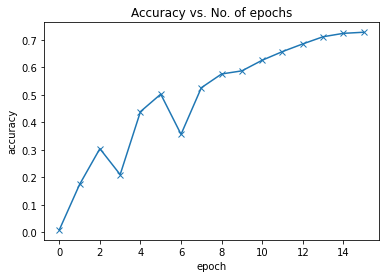

In [55]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [56]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

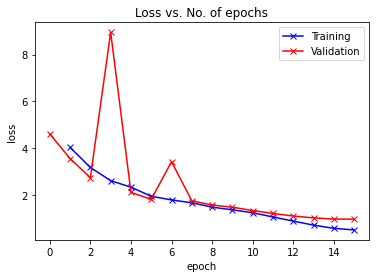

In [57]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [58]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

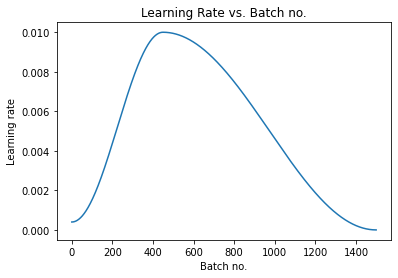

In [59]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.



In [60]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: apple , Predicted: apple


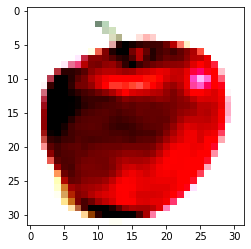

In [61]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bowl , Predicted: bowl


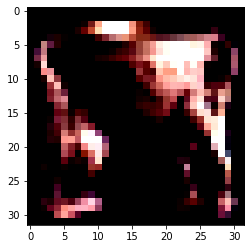

In [62]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: plate , Predicted: plate


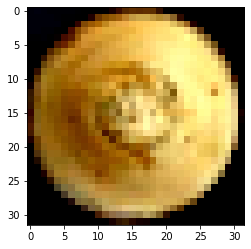

In [63]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: trout , Predicted: trout


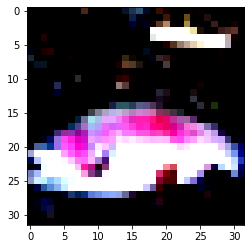

In [66]:
img, label = valid_ds[9100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: crab , Predicted: turtle


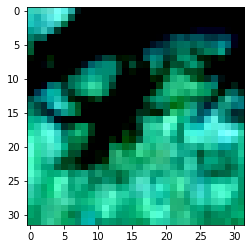

In [72]:
img, label = valid_ds[2615
                      ]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.


In [73]:
torch.save(model.state_dict(), 'cifar100-resnet18.pth')

## Summary and Further Reading

Here's a summary of the different techniques used in this notebook to improve our model performance and reduce the training time:


* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. [Learn more](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. [Learn more](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

* **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  [Learn more.](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. [Learn more.](https://ruder.io/optimizing-gradient-descent/index.html)


To improve our accuracy we can try different types of CNN architectures like Resnets-50, Xception and ResNeXt-50 etc.